<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab/v0.9.1/02_learnable_quantum_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cudaq==0.9.1

# Lab 2: Learnable Quantum Walk in Financial Simulation

**What you'll do:**
* Experiment with the Split Step Quantum Walk (SSQW), which is a generalization of the DTQW introduced in Lab 1.
* Add variational gates for the coin operators to create the multi-Split Step Quantum Walk (mSSQW)
* Use a classical optimizer to identify optimal parameters in the mSSQW that will generate a good approximation to the targeted log-normal probability distribution.

The notebook is organized as follows:
* Section 1: Introduction to the context and problem
* Section 2: Split Step Quantum Walk
* Section 3: Multi-Split Step Quantum Walk

Let's begin by installing and importing the necessary packages:

In [ ]:
import cudaq
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Below we've modified some of the code from Lab 1 that we will repurpose here.   In particular, we'll replace the `INC` and `DEC` operations for shifting the walker's position with the kernels `inc` and `dec` that are defined with gate operators as opposed to unitary operators.  The advantage with this approach is that we'll be able to create nested kernels that will simplify the exposition. The code blocks below also contain a helper function for graphing the results of the SSQW and the functions to prevent one-step transitions between the states $|{0000}\rangle$ and $|{1111}\rangle$.

Make sure to execute these cells.

In [ ]:
# Define a kernel on 4 qubits for the inc operation that
# maps |x> to |x+1> mod 16
num_qubits = 4

@cudaq.kernel
def inc(qubits : cudaq.qview):
    x.ctrl([qubits[3], qubits[2], qubits[1]], qubits[0])
    x.ctrl([qubits[3], qubits[2]], qubits[1])
    x.ctrl(qubits[3], qubits[2])
    x(qubits[3])

# Define a kernel on 4 qubits for the dec operation that
# maps |x> to |x-1> mod 16
@cudaq.kernel
def dec(qubits : cudaq.qview):
    cudaq.adjoint(inc, qubits)

In [ ]:
# Function to create a plot of the histogram of the results of the SSQW
def plot_walk_results(result, num_qubits, title):
    # Define a dictionary of results from the sampling
    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length 4
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    # Update the results dictionary of results from the circuit sampling
    for k,v in result.items():
        result_dictionary[k] = v

    # Convert the dictionary to lists for x and y values
    x = list(result_dictionary.keys())
    y = list(result_dictionary.values())

    # Create the histogram
    plt.bar(x, y, color='#76B900')

    # Add title and labels
    plt.title(title)
    plt.xlabel("Positions")
    plt.ylabel("Frequency")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Define kernels to prevent transitions between |0000> and |1111>

# Kernel to change a coin from 1 to 0 if the walker is the state |1111>
@cudaq.kernel
def no_INC_at_right_endpoint(walker_qubits : cudaq.qview, coin_qubit : cudaq.qubit, right_endpoint:cudaq.qubit):

    # Test if the coin is in |1> and the walker state is |1111>,  if so, change the end_point qubit to 1
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], right_endpoint)

    # Flip the state of the coin if the endpoint is triggered
    x.ctrl(right_endpoint, coin_qubit)


# Kernel to change a coin fron 0 to 1 if the walker is in the state |0000>
@cudaq.kernel
def no_DEC_at_left_endpoint(walker_qubits : cudaq.qview, coin_qubit : cudaq.qubit, left_endpoint: cudaq.qubit):
    # Bit Flip the walker and coin qubits
    x(coin_qubit)
    x(walker_qubits)

    # Trigger the left_endpoint qubit if the walker and the coin are now in the states |1> and |1111> respectively
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], left_endpoint)

    # Undo the bit flip on the walker and coin qubits
    x(walker_qubits)
    x(coin_qubit)

    # Flip the coin fron |0> to |1> if the endpoint qubit is triggered
    x.ctrl(left_endpoint,coin_qubit)

# Kernel to reset the coin and endpoint qubit
@cudaq.kernel()
def reset_coin_and_endpoint(coin_qubit : cudaq.qubit, endpoint: cudaq.qubit):
    # change the coin qubit back if it was flipped to prevent transitions
    # between |0000> and |1111>
    x.ctrl(endpoint, coin_qubit)

    # reset the endpoint qubit to |0>
    reset(endpoint)

## Introduction to the Context and Problem

### The Context

A significant challenge in quantum computing is the efficient encoding of classical data into quantum states that can be processed by quantum hardware or simulated on classical computers. This is particularly crucial for many financial applications, where the first step of a quantum algorithm often involves efficiently loading a probability distribution. For instance, to enable lenders to price loans more accurately based on each borrower's unique risk profile, it is essential to estimate individual loan risk distributions (such as default and prepayment) while accounting for uncertainties in modeling and macroeconomic factors. Efficiently implementing this process on a quantum computer requires the ability to load a log-normal or other complex distribution into a quantum state [(Breeden and Leonova)](https://www.tandfonline.com/doi/full/10.1080/01605682.2022.2115415).

Financial markets exhibit complex probability distributions and multi-agent interactions that classical models struggle to capture efficiently. Quantum walks can be used to generate probability distributions of market data. The quantum walk approach offers:
* Flexible modeling of price movements
* Better representation of extreme events compared to classical methods
* Ability to capture asymmetric return distributions [(Backer et al)](https://arxiv.org/pdf/2403.19502).


### The Problem

This tutorial explores the multi-split-step quantum walks (mSSQW) technique, as detailed by [Chang et al.](https://arxiv.org/pdf/2302.12500), to load a specific probability distribution into a quantum state.  Although this technique is applicable to various distributions, our focus here is on the log-normal distribution, which can model the spot price of a financial asset at maturity. Below, you will find a graph illustrating the sampling of a continuous log-normal distribution targeted in this tutorial.


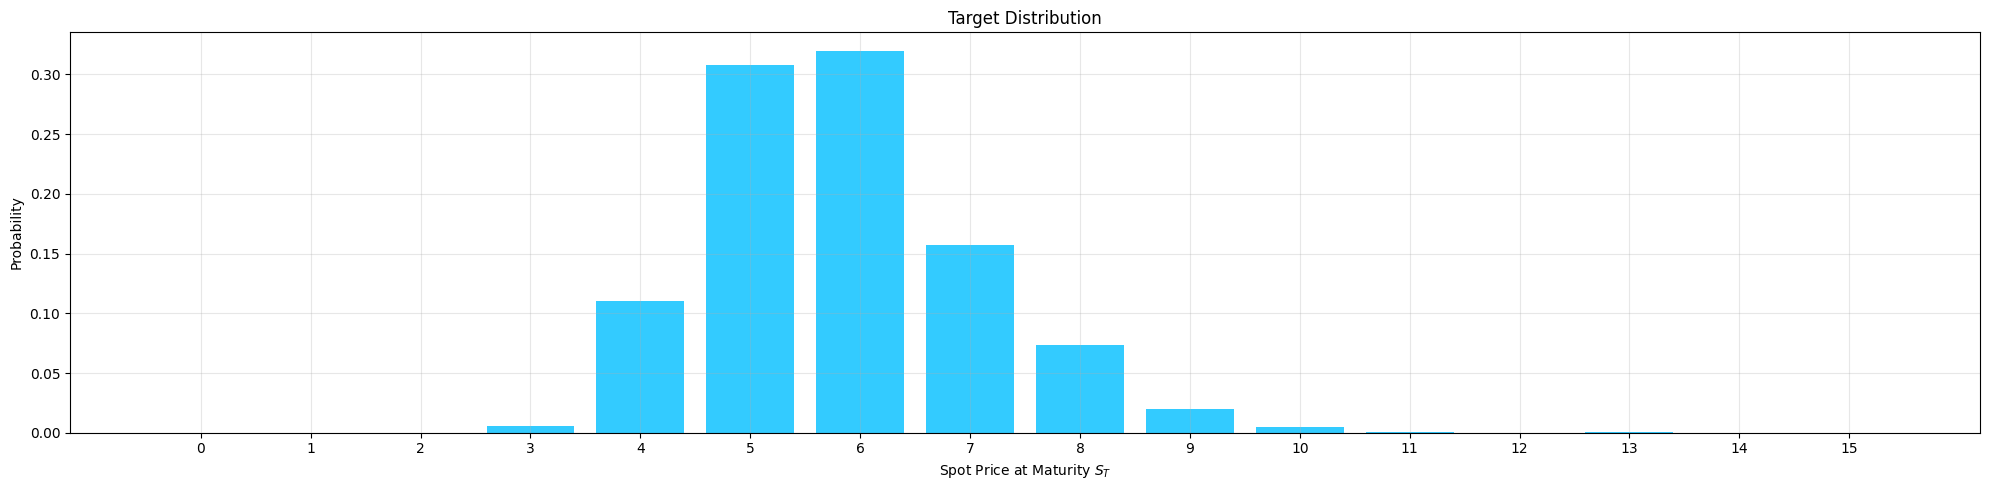

In [ ]:
# Prepare data

S = 6.0  # initial spot price
vol = 0.4  # volatility (40%)
r = 0.04  # annual interest rate (4%)
T = 90 / 365  # 90 days to maturity


def prepare_data(S, vol, r, T, N=2**10, num_qubits=4):
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)
    mean = np.exp(mu + sigma**2 / 2)
    std_dev = np.sqrt((np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2))

    # lowest and highest value considered for the spot price
    low, high = np.maximum(0, mean - 3 * std_dev), mean + 3 * std_dev

    # Sample from the log-normal distribution
    np.random.seed(42)
    log_normal_samples = np.clip(np.round(np.random.lognormal(mean=mu, sigma=sigma, size=N) * 2) / 2, 0, 2**num_qubits)

    # Calculate and return the target distribution from log-normal distribution
    bins = np.arange(2**num_qubits + 1)
    target = np.bincount(log_normal_samples.astype(int), minlength=len(bins) - 1)
    return target / target.sum()


target = prepare_data(S, vol, r, T)

# Plot the target distribution
fig, ax1 = plt.subplots(figsize=(20, 5))  # Increased figure width to accommodate all ticks

# Quantum walk vs. target distribution comparison
x = np.arange(len(target))
ax1.bar(x, target, color='#00BFFF', alpha=0.8)
ax1.set(title='Target Distribution', xlabel='Spot Price at Maturity $S_T$', ylabel='Probability')
ax1.set_xticks(np.arange(len(target)))
ax1.tick_params(axis='x', which='major', labelbottom=True)
ax1.grid(alpha=0.3)

plt.tight_layout()  # Use this to avoid labels and titles being cut off
plt.show()

## Split Step Quantum Walk

The aim of this tutorial is to load the targeted distribution, graphed above, into a quantum state using quantum walks.  Before getting into the details of the mSSQW, let's first define the ***split-step quantum walk (SSQW)***.

SSQW is an extension of the DTQW introduced in Lab 1.  For the SSQW, each time step is split into two actions determined by the outcome of two coin flips, hence the name "split step." As was the case in the DTQW, instead of classical coins that can be in the discrete states heads or tails, we use the single-qubit quantum state $|{\psi_{C}}\rangle$ to represent the state of the coin.

In contrast to the DTQW, the SSQW involves flipping the coin twice for each time step. The first flip determines whether the state of the walker shifts right, and the second flip determines whether the state of the walker shifts left. That is, we will apply a quantum coin flip operation $F_1$ on $|{\psi_{C}}\rangle$. The outcome of this flip, $F_1 |{\psi_{C}}\rangle$, will determine whether the walker's state shifts to the right or remains unchanged. Next, during this time step, we apply another, possibly different, quantum operation $F_2$ on the same coin. This outcome, $F_2(F_1 |{\psi_{C}}\rangle)$, determines whether the walker's state shifts to the left or remains unchanged. The circuit diagram for one time step of the SSQW algorithm is given below.

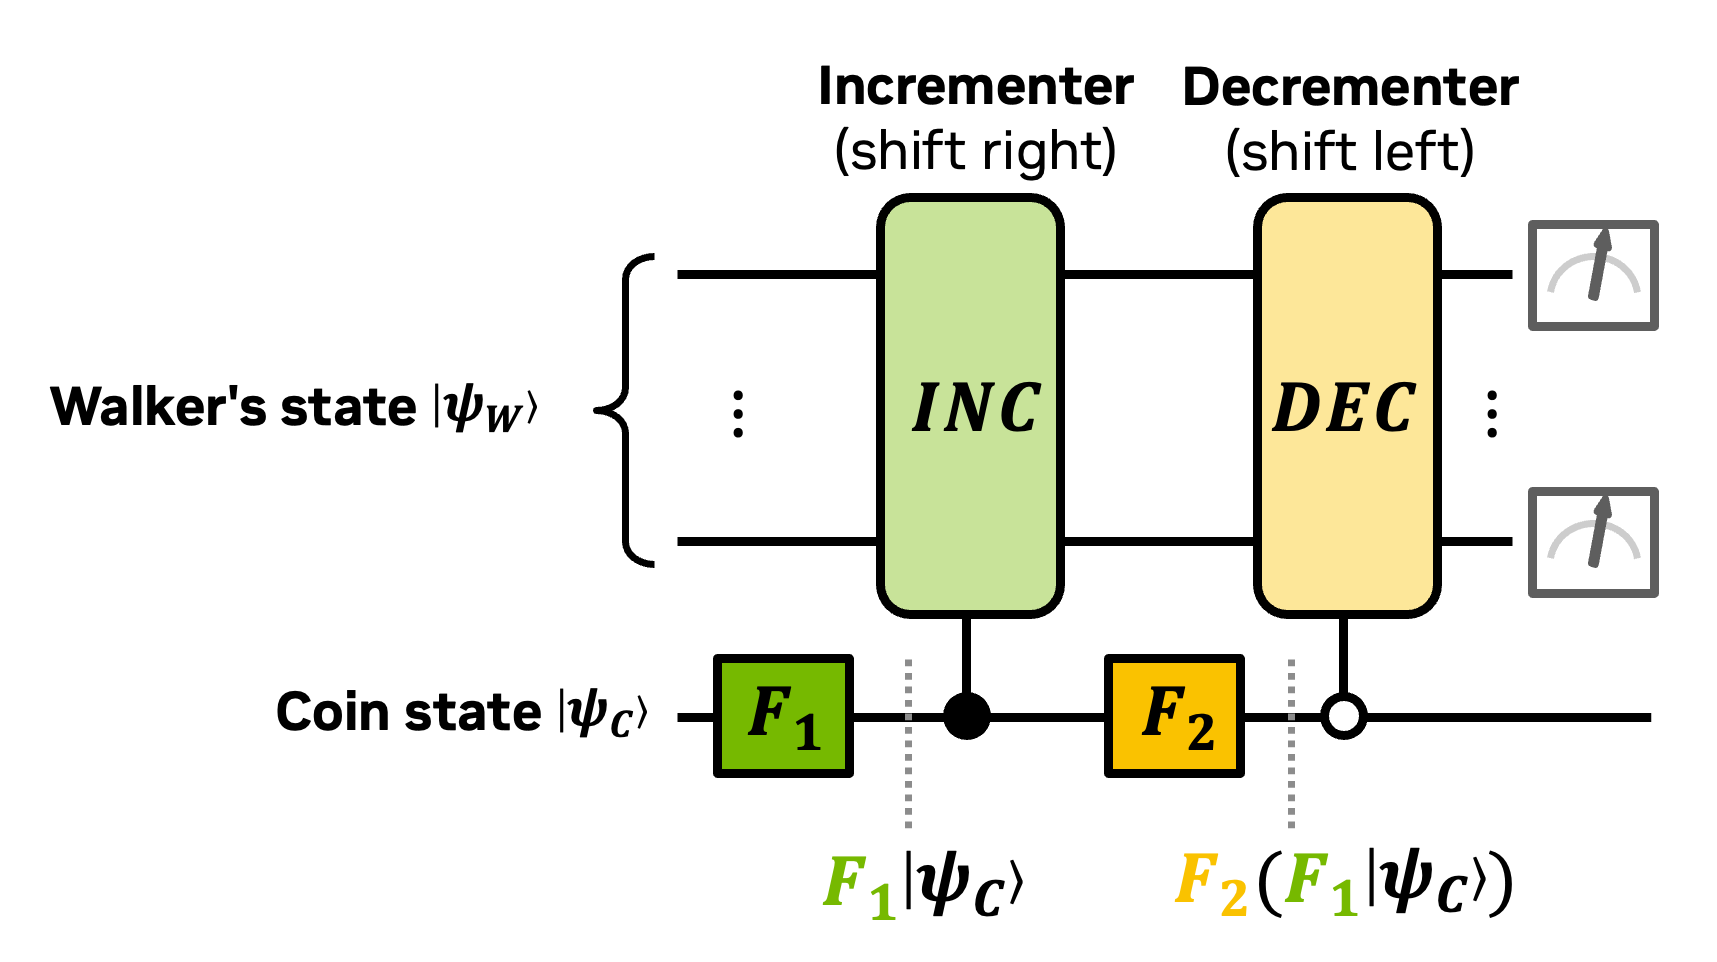

Additionally, since our goal is to model financial data, we must avoid scenarios where the walker with one coin flip moves directly between positions $|{0000}\rangle$ and $|{1111}\rangle$. Such transitions might suggest an investor with positive sentiment about the stock’s value encoded as $|{1111}\rangle$ would sell it at a very low price near the value encoded as $|{0000}\rangle$. To prevent this, we use an auxiliary qubit `endpoint_qubit`, as we did in Lab 1. The SSQW with an additional endpoint qubit is depicted as follows:

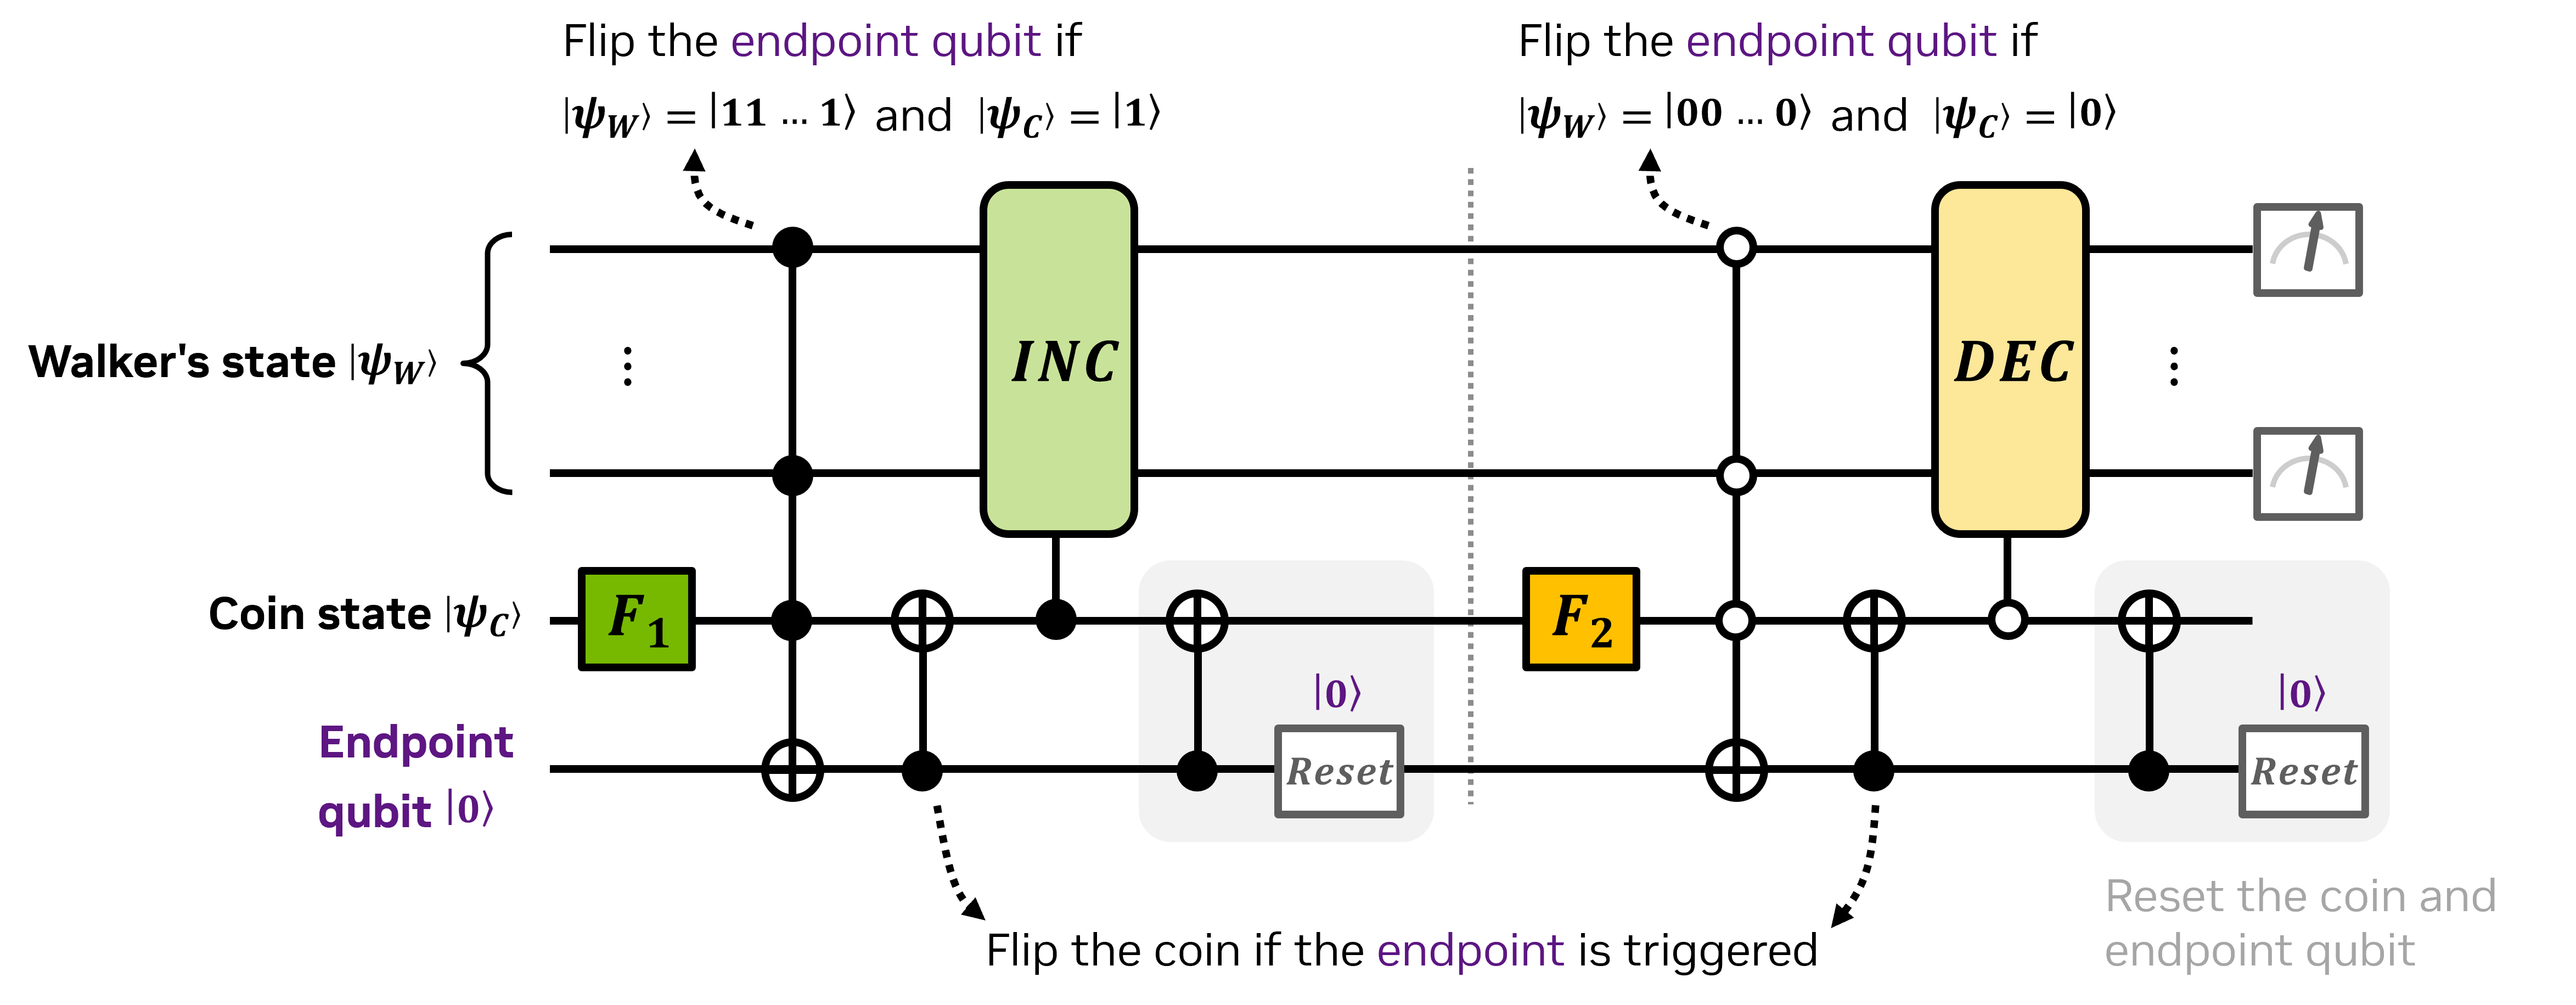

We've coded the SSQW below using two different coin operations $F_1 = H$ and $F_2 = X$ and disallowing movement of the walker between position $|{0000}\rangle$ and $|{1111}\rangle$. Feel free to experiment with different combinations of the following:  

* initial states of the coin  
* initial states of the walker  
* coin operations (e.g., `h`, `t`, `z`, etc.)  
* `num_time_steps`  

For instance, you might select initial states and coin operators to verify that regardless of the coin, a walker beginning in state $|{0000}\rangle$ will not move to $|{1111}\rangle$ in one time step.

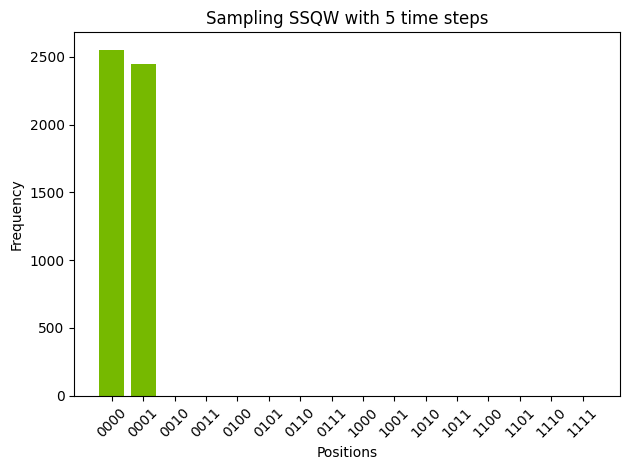

In [ ]:
# Set the number of steps
num_time_steps = 5 #CHANGE_ME

# Set the number of qubits Do Not Change without changing inc and dec
num_qubits = 4

# Kernel for one step of the SSQW without measurement
@cudaq.kernel
def SSQW_one_step_gates(walker_qubits : cudaq.qview, coin_qubit : cudaq.qubit, endpoint_qubit : cudaq.qubit):

    # One quantum walk step

    # First flip of the coin with the first coin operation, F1
    x(coin_qubit)      #CHANGE_ME

    # Walker's position change
    # Avoid shifting from |1111> to |0000> in case the coin is |1> by flipping the coin to |0>
    no_INC_at_right_endpoint(walker_qubits, coin_qubit, endpoint_qubit)

    # Shift to the right if the coin is |1> and the position is not |1111>
    cudaq.control(inc, coin_qubit, walker_qubits)

    # Reset the coin and endpoints in case they were changed to avoid moving from |1111> to |0000>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)


    # Second flip of the coin with the second coin operation, F2
    h(coin_qubit)      #CHANGE_ME

    # Controlled-decrementer
    # Avoid shifting from |0000> to |1111> in case the coin is |0> by flipping the coin to |1>
    no_DEC_at_left_endpoint(walker_qubits, coin_qubit, endpoint_qubit)

    # Apply the dec if the the coin is in |0>
    x(coin_qubit)
    cudaq.control(dec, coin_qubit, walker_qubits)
    x(coin_qubit)

    # Reset the coin and endpoints in case they were changed to avoid moving from |0000> to |1111>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)

@cudaq.kernel()
def SSQW_with_measurement(num_qubits : int, num_time_steps : int):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qubit()
    endpoint_qubit = cudaq.qubit()

    # Initial walker state 1/sqrt(2)(|1000> + |0000>) #CHANGE_ME
    #h(walker_qubits[0])
    #x(walker_qubits)


    # Initial coin state    #CHANGE_ME
    #h(coin_qubit) #Uncomment this line to start with a superposition of heads and tails

    for _ in range(num_time_steps):
        SSQW_one_step_gates(walker_qubits, coin_qubit, endpoint_qubit)

    # Measure the walker's state
    mz(walker_qubits)

#cudaq.draw(SSQW_with_measurement, num_qubits, num_time_steps)

# Sample the kernel for the quantum walk
result = cudaq.sample(SSQW_with_measurement, num_qubits, num_time_steps, shots_count=5000)


title = 'Sampling SSQW with {} time steps'.format(num_time_steps)
plot_walk_results(result, num_qubits, title)

## Multi-Split Step Quantum Walk

As you might have noticed in the previous section, by varying the initial state of the walker and coin, and experimenting with different coin flip operations, we can generate many different distributions.  Another variation to consider is to change the coin operations, $F_1$ and $F_2$, throughout the walk.  For example, perhaps we start with two bit flip operations to change the state of the coin in time step one and then switch to two Hadamard operations on the coin in time step 2.  Go ahead and edit the code block above to observe the new generated probability distribution.  

The challenge, and the focus of the remainder of this tutorial, is to identify initial states and coins that will generate a targeted probability distribution. To keep things simple, we'll fix the initial states of the coin and the walker. Using parameterized coin operations, we can employ a classical optimizer to iteratively evolve the system to generate the desired distribution.

What we've just described is the ***multi-Split-Step Quantum Walk (multi-SSQW)*** framework, which we have depicted below for one time step. To adapt this for multiple time steps, the multi-SSQW quantum circuit is replaced with one made up of `num_time_steps` copies of the block sequence of the $k$ investor's split steps.   In a financial application, the different coin operations at each time step can represent distinct investors' decision-making processes reflecting positive or negative sentiment about the value of the stock. The investor's actions can affect a stock price that is being modeled by the probability distribution.

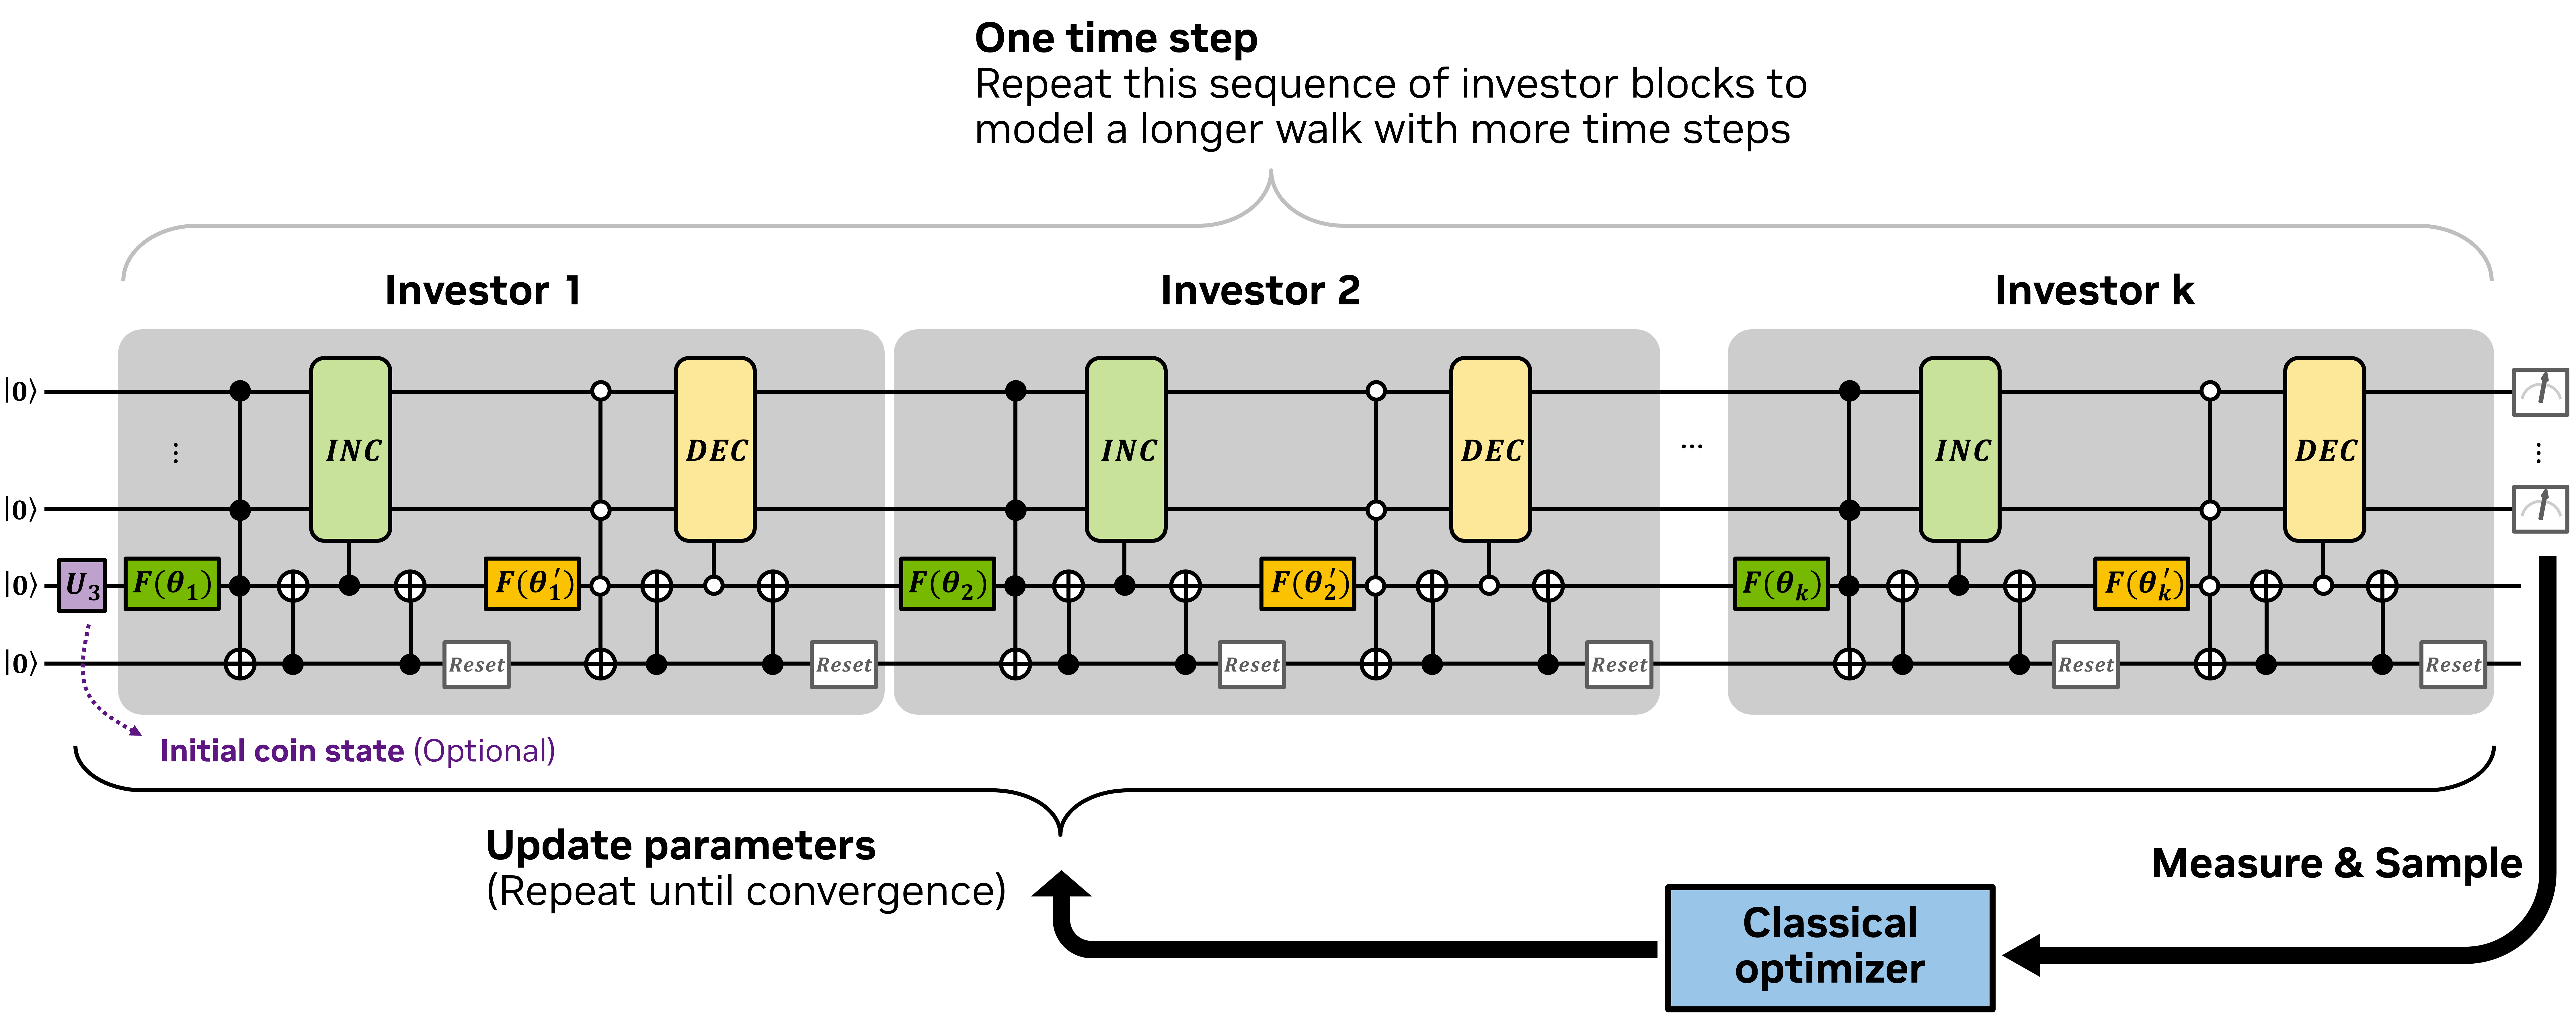

We've encoded the multi-SSQW circuit below using the [universal three-parameter gate](https://nvidia.github.io/cuda-quantum/latest/api/default_ops.html#u3), `u3`, for the coin flip operators.

In [ ]:
# Initialize the quantum walk kernel and position shift
# Fixed variable do not change
num_qubits = 4 # Number of qubits representing the state of the walker

# Variables that you can experiment with
num_investors = 3 # Number of investors
num_time_steps = 4 # Number of repetitions of the Investors' walk
shots_count = 10000

@cudaq.kernel
def multiSSQW_kernel(num_qubits: int, num_investors: int, num_time_steps : int, param : list[float]):
    """ kernel for the multi-SSQW circuit for num_investors and num_time_steps
    Parameters
        num_qubits : int
        Number of qubits for the walker's state

        num_investors : int
        Number of split-step pairs in one time step

        num_time_steps : int
        Number of iterations of the investor's split steps

        param : list[float]
        Parameters for the coin operators
    """
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qubit()
    endpoint_qubit = cudaq.qubit()
    # Initial walker state |0101>
    x(walker_qubits[1])
    x(walker_qubits[3])

    # Initial coin state (optional)
    u3(param[0], param[1], param[2], coin_qubit)

    for _ in range(num_time_steps):
        # Quantum walk split steps of all the investors
        for k in range(num_investors):
            # Split step of one investor


            # First coin operation
            u3(param[(k+1)*6-3], param[(k+1)*6-2], param[(k+1)*6-1], coin_qubit)

            # Walker's position change
            # Avoid shifting from |1111> to |0000> in case the coin is |1> by flipping the coin to |0>
            no_INC_at_right_endpoint(walker_qubits, coin_qubit, endpoint_qubit)
            # Shift to the right if the coin is |1> and the position is not |1111>
            cudaq.control(inc, coin_qubit, walker_qubits)

            # Reset the coin and endpoints in case they were changed to avoid moving from |1111> to |0000>
            reset_coin_and_endpoint(coin_qubit, endpoint_qubit)


            # Second coin operation
            u3(param[(k+1)*6], param[(k+1)*6+1], param[(k+1)*6+2], coin_qubit)

            # Controlled-decrementer
            # Avoid shifting from |0000> to |1111> in case the coin is |0> by flipping the coin to |1>
            no_DEC_at_left_endpoint(walker_qubits, coin_qubit, endpoint_qubit)

            # Apply the DEC if the the coin is in |0>
            x(coin_qubit)
            cudaq.control(dec, coin_qubit, walker_qubits)
            x(coin_qubit)

            # Reset the coin and endpoints in case they were changed to avoid moving from |0000> to |1111>
            reset_coin_and_endpoint(coin_qubit, endpoint_qubit)

    # Measure the state of the walker
    mz(walker_qubits)

The code block below defines functions for the classical optimization in the multi-SSQW hybrid workflow. We've selected the COYBLA classical optimizer and the mean square error (MSE) cost function for this example, but other optimizers and cost functions could easily be substituted.

In [ ]:
def quantum_walk_simulation(kernel, num_qubits, num_investors, num_time_steps, param):
    """
    Execute the multi-SSQW kernel with the given gate parameters
    Parameters
        kernel : cudaq.kernel parameterized kernel to be sampled
        num_qubits, num_investors, num_time_steps: parameters defining the kernel
        param : float values for the gate parameters in the kernel
    Returns
        probs : dict
        dictionary where the keys are bit strings of length 4 and float values are
        probabilities resulting from kernel sampling
    """
    # Sample the kernel
    result = cudaq.sample(kernel, num_qubits, num_investors, num_time_steps, param, shots_count=shots_count)

    # Convert the results first to a dictionary then to a list of probabilities
    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length 4 to initialize the result_dictionary
    for i in range(2**4):
        bitstr = bin(i)[2:].zfill(4)
        result_dictionary[bitstr] = 0

    # Update the results_dictionary with the results from the circuit sampling
    for k,v in result.items():
        result_dictionary[k] = v/shots_count

    # Convert the dictionary to list of probabilities
    probs = list(result_dictionary.values())
    return probs


def optimize_distribution(kernel, num_qubits, num_investors, num_time_steps, target, max_iter=250):
    """
    Optimize the quantum walk parameters to match the target distribution
    """
    errors = []
    best_error, best_params = float('inf'), None

    # Define the cost function as a mean square error between the results of the sampling of the kernel
    # with given parameters and the targeted distribution
    def cost_function(params):
        trained = quantum_walk_simulation(kernel, num_qubits, num_investors, num_time_steps, params)
        return np.mean((trained - target)**2)

    def callback(xk):
        errors.append(cost_function(xk))

    # Randomly initialize parameters
    random.seed(42)
    x0 = [random.uniform(0, np.pi) for _ in range(6*num_investors + 3)]


    # Optimize
    result = minimize(cost_function, x0=x0, method="COBYLA", options={'maxiter': max_iter}, callback=callback )
    if result.fun < best_error:
        best_error = result.fun
        best_params = result.x

    print(f"Current best error: {best_error}")

    return best_params, errors, best_error

Now it's time to execute the multi-SSQW and plot the results!

In [ ]:
# Define the simulation target
cudaq.set_target("qpp-cpu")  # For simulation on CPU

# Optimize to get the final distribution
best_params, errors, final_error = optimize_distribution(multiSSQW_kernel, num_qubits, num_investors, num_time_steps, target)

# Simulate the quantum walk with the best parameters
qw = quantum_walk_simulation(multiSSQW_kernel, num_qubits, num_investors, num_time_steps, best_params)

Current best error: 0.00012139246887207033


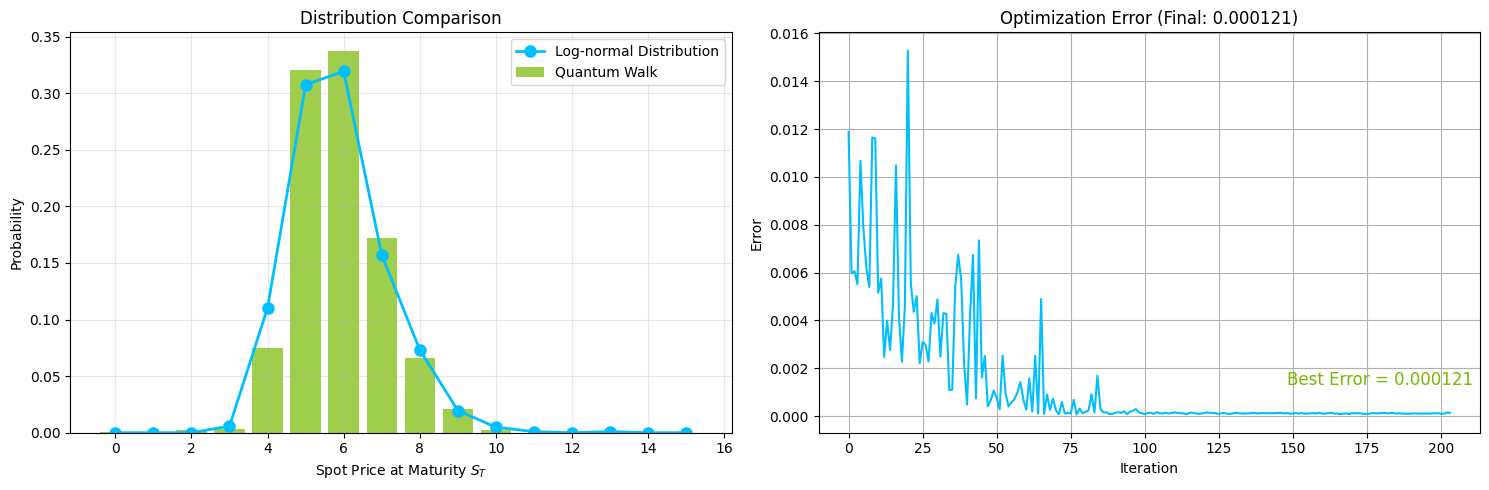

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Quantum walk vs. target distribution comparison
x = np.arange(len(target))
ax1.bar(x, qw, width=0.8, color='#76B900', alpha=0.7, label='Quantum Walk')
ax1.plot(x, target, '-o', color='#00BFFF', linewidth=2, markersize=8, label='Log-normal Distribution')
ax1.set(title='Distribution Comparison', xlabel='Spot Price at Maturity $S_T$', ylabel='Probability')
ax1.grid(alpha=0.3)
ax1.legend()

# Optimization errors plot
ax2.plot(errors, label='Error', color = '#00BFFF')
ax2.set(title=f'Optimization Error (Final: {final_error:.6f})', xlabel='Iteration', ylabel='Error')
ax2.grid(True)
ax2.annotate(f'Best Error = {final_error:.6f}', xy=(len(errors)-1, final_error), xytext=(-50, 20),
             textcoords='offset points', ha='center', fontsize=12, color='#76B900')

plt.tight_layout()
plt.show()